In [1]:
# Import the keys
import os
from dotenv import load_dotenv
load_dotenv()

WEATHER_API_KEY = os.environ['WEATHER_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']


# Retrieve credentials from environment variables
openai_api_version = os.getenv("OPENAI_API_VERSION")

azure_openai_endpoint = os.getenv("ENDPOINT_URL_MINI")
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_MINI")
deployment_name="shrawan-gpt-4o-mini"

groq_api_key=os.getenv('GROQ_API_KEY')
print(deployment_name)


shrawan-gpt-4o-mini


In [2]:
# Import the required libraries and methods
import requests
from typing import List, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI


## GROQ

In [3]:
# from langchain_groq import ChatGroq
# from langchain_core.prompts import ChatPromptTemplate

# # Initialize the ChatGroq model
# llm = ChatGroq(
#     model="llama-3.3-70b-versatile",
#     temperature=0.5,
#     api_key=groq_api_key
# )
# llm


In [4]:
# If you have OpenAI key
# llm = ChatOpenAI(model="gpt-4o-mini", api_key="sk-U7tijaa4jwHvhVWGr....", temperature=0)


## if you have azure openai

from langchain_openai import AzureChatOpenAI




if not os.environ.get("AZURE_OPENAI_API_KEY"):
  os.environ["AZURE_OPENAI_API_KEY"] = azure_openai_api_key

llm = AzureChatOpenAI(
    azure_endpoint=azure_openai_endpoint,
    azure_deployment=deployment_name,
    openai_api_version=openai_api_version,
)


In [5]:
llm.invoke("hi")


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, '

In [6]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

### APIs to Simulate
You are required to simulate at least 3 out of the 5 following APIs using functions. The agent
should dynamically determine the right function(s) to call based on the user&#39;s query and
retain context for follow-up questions.

#### Financial Data Function

Function Name: `get_financial_data(query)`
Example Queries:
- What is the stock price of Tesla?
- How is Bitcoin performing today?

#### Weather Function
Function Name: `get_weather(query)`
Example Queries:
- What&#39;s the weather like in Tokyo?
- Will it rain in New York tomorrow?


#### News Function
Function Name: `get_news(query)`
Example Queries:
- Tell me the latest news about AI.
- Any updates on the electric vehicle industry?


#### Sentiment Analysis Function
Function Name: `analyze_sentiment(query)`
Example Queries:

- Analyze the sentiment of &#39;The product is amazing, but delivery was slow.&#39;
- What do people think about OpenAI?


#### Translation Function
Function Name: `translate_text(query)`
Example Queries:
- Translate &#39;How are you?&#39; into French.
- How do you say &#39;Good morning&#39; in Spanish?

In [7]:
from openai import AzureOpenAI
client = AzureOpenAI(  
    azure_endpoint=azure_openai_endpoint,  
    api_key=azure_openai_api_key,  
    api_version="2024-05-01-preview",  
)

In [8]:
def translate(client, model, query):
    prompt='''your are an efficient translator, who first analyze the query and its language and then translate it to the target language.
    ## given Query: {query}
    Note : in output only provide the translation of the query, nothing else.
    '''
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant that translate the given sentence"
        },
        {
            "role": "user",
            "content": prompt,
        }
    ]

    stream = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
        
    )
    return stream


def sentiment(client, model, query):
    prompt = f'''
    You are a sentiment analyzer. First, analyze the sentiment of the given query and detect its language. Then, provide the sentiment analysis result.
    ## Given Query: {query}
    Note: In the output, only provide the sentiment result, nothing else.
    '''
    
    messages = [
        {"role": "system", "content": "You are a helpful assistant that performs sentiment analysis."},
        {"role": "user", "content": prompt},
    ]

    stream = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
        
    )
    return stream

In [9]:
@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather"""
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(endpoint)
    data = response.json()

    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"

@tool
def get_news(query: str) -> list:
    """Search the news from web"""
    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=4, search_depth='advanced', max_tokens=1000)
    results = tavily_search.invoke(query)
    return results


@tool
def translate_text(query: str)-> str:
    """
    Translates the given query text into the target language using the deployed model.
    
    Args:
        query (str): The text to be translated.

    Returns:
        str: The translated text.
    """
    translated_text=translate(client, deployment_name, query)
    translated_text=translated_text.choices[0].message.content
    return translated_text






@tool
def analyze_sentiment(query: str) -> str:
    """
    Performs sentiment analysis on the provided query.
    
    This function utilizes the sentiment analysis model to evaluate the input query and returns the sentiment classification.
    
    Args:
        query (str): The text input for sentiment analysis.
    
    Returns:
        str: The sentiment analysis result.
    """
    sentiment_analyzer = sentiment(client, deployment_name, query)
    sentiment_analyzer = sentiment_analyzer.choices[0].message.content
    return sentiment_analyzer

    

In [10]:
tools = [get_weather, get_weather, translate_text, analyze_sentiment]
llm_with_tools = llm.bind_tools(tools)

In [11]:
tools = [get_weather, get_news, translate_text, analyze_sentiment]
tool_node = ToolNode(tools)

tool_node

tools(tags=None, recurse=True, func_accepts_config=True, func_accepts={'writer': False, 'store': True}, tools_by_name={'get_weather': StructuredTool(name='get_weather', description='Search weatherapi to get the current weather', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x10ed64720>), 'get_news': StructuredTool(name='get_news', description='Search the news from web', args_schema=<class 'langchain_core.utils.pydantic.get_news'>, func=<function get_news at 0x10ed647c0>), 'translate_text': StructuredTool(name='translate_text', description='Translates the given query text into the target language using the deployed model.\n\nArgs:\n    query (str): The text to be translated.\n\nReturns:\n    str: The translated text.', args_schema=<class 'langchain_core.utils.pydantic.translate_text'>, func=<function translate_text at 0x10ed64860>), 'analyze_sentiment': StructuredTool(name='analyze_sentiment', description='Performs sentiment analysis on 

In [12]:
def call_model(state: MessagesState):
    messages = state["messages"]
    print("----------------------------------call_model----------------------------------------")
    print(messages)
    print("----------------------------------call_model----------------------------------------")
    response = llm_with_tools.invoke(messages)
    print("---------------------------------------------")
    return {"messages": [response]}
    print("++++++++++++++++++++++++++++++++++++++++++++++++")

def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    print("----------------------------------call_tools----------------------------------------")
    print(messages)
    last_message = messages[-1]
    print(last_message)
    check_tool=last_message.tool_calls
    print("called tool info:", check_tool)
    print("----------------------------------call_tools----------------------------------------")
    
    if check_tool:
        return "tools"
    return END

In [13]:
# initialize the workflow from StateGraph
workflow = StateGraph(MessagesState)

# add a node named LLM, with call_model function. This node uses an LLM to make decisions based on the input given
workflow.add_node("LLM", call_model)

# Our workflow starts with the LLM node
workflow.add_edge(START, "LLM")

# Add a tools node
workflow.add_node("tools", tool_node)

# Add a conditional edge from LLM to call_tools function. It can go tools node or end depending on the output of the LLM. 
workflow.add_conditional_edges("LLM", call_tools)

# tools node sends the information back to the LLM
workflow.add_edge("tools", "LLM")

agent = workflow.compile()

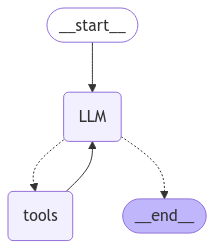

In [14]:
from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
for chunk in agent.stream(
    {"messages": [("user", "I hate you")]},
    stream_mode="values",):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I hate you
----------------------------------call_model----------------------------------------
[HumanMessage(content='I hate you', additional_kwargs={}, response_metadata={}, id='d768a265-ba98-4235-b2ac-3d9c7e9f8d60')]
----------------------------------call_model----------------------------------------
---------------------------------------------
----------------------------------call_tools----------------------------------------
[HumanMessage(content='I hate you', additional_kwargs={}, response_metadata={}, id='d768a265-ba98-4235-b2ac-3d9c7e9f8d60'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sqdC6mNDDAM6Ce4W94j8W0DT', 'function': {'arguments': '{"query":"I hate you"}', 'name': 'analyze_sentiment'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 184, 'total_tokens': 202, 'completion_tokens_details': {'accept

In [19]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from typing import TypedDict, Optional
import json
import re

# Define state structure
class AgentState(TypedDict):
    query: str
    intent: Optional[str]
    entities: Optional[dict]
    result: Optional[str]



# Mock services (same as before)
def get_weather(location):
    return f"Weather in {location}: 72°F, Sunny"

def get_news(topic):
    return f"Latest news about {topic}: AI breakthroughs announced!"

def translate_text(text, target_lang):
    return f"Translated to {target_lang}: {text}"

# Nodes implementation
def intent_parser(state: AgentState) -> dict:
    query = state["query"]
    
    prompt = f"""Analyze this query and respond in JSON format:
    {query}

    Response format:
    {{
        "intent": "weather|news|translation",
        "entities": {{
            "location": "...",
            "topic": "...",
            "text": "...",
            "target_lang": "..."
        }}
    }}"""
    
    response = llm.invoke([HumanMessage(content=prompt)]).content
    try:
        parsed = json.loads(re.search(r'\{.*\}', response, re.DOTALL).group())
        return {
            "intent": parsed["intent"],
            "entities": parsed["entities"]
        }
    except:
        return {"result": "Could not understand request"}

def weather_node(state: AgentState) -> dict:
    location = state["entities"].get("location", "unknown location")
    return {"result": get_weather(location)}

def news_node(state: AgentState) -> dict:
    topic = state["entities"].get("topic", "general")
    return {"result": get_news(topic)}

def translation_node(state: AgentState) -> dict:
    entities = state["entities"]
    text = entities.get("text", "")
    target_lang = entities.get("target_lang", "French")
    return {"result": translate_text(text, target_lang)}

# Create workflow
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("intent_parser", intent_parser)
workflow.add_node("weather", weather_node)
workflow.add_node("news", news_node)
workflow.add_node("translation", translation_node)

# Set entry point
workflow.set_entry_point("intent_parser")

# Add conditional edges
def route_based_on_intent(state: AgentState):
    intent = state.get("intent")
    if intent == "weather":
        return "weather"
    elif intent == "news":
        return "news"
    elif intent == "translation":
        return "translation"
    else:
        return "end"

workflow.add_conditional_edges(
    "intent_parser",
    route_based_on_intent,
    {
        "weather": "weather",
        "news": "news",
        "translation": "translation",
        "end": END
    }
)

# Add edges for service nodes
workflow.add_edge("weather", END)
workflow.add_edge("news", END)
workflow.add_edge("translation", END)

# Compile the graph
agent = workflow.compile()

# Run the agent
def run_agent(query):
    result = agent.invoke({"query": query})
    return result.get("result", "No response generated")

# Example usage (same as before)
if __name__ == "__main__":
    queries = [
        "What's the weather in Tokyo?",
        "Give me news about artificial intelligence",
        "Translate 'Good morning' to Spanish",
        "Tell me something random"
    ]

    for query in queries:
        print(f"Query: {query}")
        print(f"Response: {run_agent(query)}\n")

Query: What's the weather in Tokyo?
Response: Weather in Tokyo: 72°F, Sunny

Query: Give me news about artificial intelligence
Response: Latest news about artificial intelligence: AI breakthroughs announced!

Query: Translate 'Good morning' to Spanish
Response: Translated to Spanish: Good morning

Query: Tell me something random
Response: No response generated



In [20]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from typing import TypedDict, Optional
import json
import re

# Define the state structure
class AgentState(TypedDict):
    query: str
    intent: Optional[str]
    entities: Optional[dict]
    result: Optional[str]

# Initialize the language model client
# llm = ChatOpenAI(api_key='your_openai_api_key')  # Replace with your actual API key

# Define the intent parser node
def intent_parser(state: AgentState) -> dict:
    query = state["query"]
    
    prompt = f"""Analyze this query and respond in JSON format:
    {query}

    Response format:
    {{
        "intent": "weather|news|translation|sentiment",
        "entities": {{
            "location": "...",
            "topic": "...",
            "text": "...",
            "target_lang": "..."
        }}
    }}"""
    
    response = llm.invoke([HumanMessage(content=prompt)]).content
    try:
        parsed = json.loads(re.search(r'\{.*\}', response, re.DOTALL).group())
        return {
            "intent": parsed["intent"],
            "entities": parsed["entities"]
        }
    except:
        return {"result": "Could not understand the request"}

# Define the weather node
def weather_node(state: AgentState) -> dict:
    location = state["entities"].get("location", "unknown location")
    return {"result": f"Weather in {location}: 72°F, Sunny"}  # Mocked response

# Define the news node
def news_node(state: AgentState) -> dict:
    topic = state["entities"].get("topic", "general")
    return {"result": f"Latest news about {topic}: AI breakthroughs announced!"}  # Mocked response

# Define the translation node
def translation_node(state: AgentState) -> dict:
    entities = state["entities"]
    text = entities.get("text", "")
    target_lang = entities.get("target_lang", "French")
    prompt = f'''You are an efficient translator. Translate the following text to {target_lang}:
    "{text}"
    Note: Provide only the translated text.'''
    
    messages = [
        {"role": "system", "content": "You are a helpful assistant that translates the given sentence."},
        {"role": "user", "content": prompt},
    ]

    response = llm.invoke(messages).content
    return {"result": response.strip()}

# Define the sentiment analysis node
def sentiment_node(state: AgentState) -> dict:
    text = state["entities"].get("text", "")
    prompt = f'''You are a sentiment analyzer. Analyze the sentiment of the following text:
    "{text}"
    Note: Provide only the sentiment result (e.g., Positive, Negative, Neutral).'''
    
    messages = [
        {"role": "system", "content": "You are a helpful assistant that performs sentiment analysis."},
        {"role": "user", "content": prompt},
    ]

    response = llm.invoke(messages).content
    return {"result": response.strip()}

# Create the workflow
workflow = StateGraph(AgentState)

# Add nodes to the workflow
workflow.add_node("intent_parser", intent_parser)
workflow.add_node("weather", weather_node)
workflow.add_node("news", news_node)
workflow.add_node("translation", translation_node)
workflow.add_node("sentiment", sentiment_node)

# Set the entry point
workflow.set_entry_point("intent_parser")

# Define the routing function based on intent
def route_based_on_intent(state: AgentState):
    intent = state.get("intent")
    if intent == "weather":
        return "weather"
    elif intent == "news":
        return "news"
    elif intent == "translation":
        return "translation"
    elif intent == "sentiment":
        return "sentiment"
    else:
        return "end"

# Add conditional edges
workflow.add_conditional_edges(
    "intent_parser",
    route_based_on_intent,
    {
        "weather": "weather",
        "news": "news",
        "translation": "translation",
        "sentiment": "sentiment",
        "end": END
    }
)

# Add edges for service nodes
workflow.add_edge("weather", END)
workflow.add_edge("news", END)
workflow.add_edge("translation", END)
workflow.add_edge("sentiment", END)

# Compile the graph
agent = workflow.compile()

# Function to run the agent
def run_agent(query):
    result = agent.invoke({"query": query})
    return result.get("result", "No response generated")

# Example usage
if __name__ == "__main__":
    queries = [
        "What's the weather in Tokyo?",
        "Give me news about artificial intelligence",
        "Translate 'Good morning' to Spanish",
        "Analyze the sentiment of 'I am very happy today!'"
    ]

    for query in queries:
        print(f"Query: {query}")
        print(f"Response: {run_agent(query)}\n")


Query: What's the weather in Tokyo?
Response: Weather in Tokyo: 72°F, Sunny

Query: Give me news about artificial intelligence
Response: Latest news about artificial intelligence: AI breakthroughs announced!

Query: Translate 'Good morning' to Spanish
Response: "Buenos días"

Query: Analyze the sentiment of 'I am very happy today!'
Response: Positive



In [23]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from typing import TypedDict, Optional
import json
import re
import requests
from langchain_community.tools import TavilySearchResults




# Define state structure
class AgentState(TypedDict):
    query: str
    intent: Optional[str]
    entities: Optional[dict]
    result: Optional[str]

# Function to get weather information
def get_weather(location: str) -> str:
    """Fetches the current weather for a given location using WeatherAPI."""
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={location}"
    response = requests.get(endpoint)
    data = response.json()

    if data.get("location"):
        location_name = data["location"]["name"]
        temp_c = data["current"]["temp_c"]
        condition = data["current"]["condition"]["text"]
        return f"Weather in {location_name}: {temp_c}°C, {condition}"
    else:
        return "Weather data not found."

def get_news(topic: str) -> str:
    """Fetches the latest news about a given topic using Tavily Search."""
    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=4, search_depth='advanced', max_tokens=1000)
    results = tavily_search.invoke({"query": topic})
    
    if results:
        news_items = []
        for item in results:
            title = item.get('title', 'No title available')
            snippet = item.get('snippet', 'No snippet available')
            news_items.append(f"- {title}: {snippet}")
        
        return f"Latest news about {topic}:\n" + "\n".join(news_items)
    else:
        return "No news found on this topic."


# Function to translate text
def translate_text(client, model, text: str, target_lang: str) -> str:
    """Translates the given text into the target language using the provided model."""
    prompt = f'''You are an efficient translator. Translate the following text to {target_lang}:
    ## Given Text: {text}
    Note: In the output, only provide the translation of the text, nothing else.'''
    
    messages = [
        {"role": "system", "content": "You are a helpful assistant that translates the given sentence."},
        {"role": "user", "content": prompt},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
    )
    return response.choices[0].message.content.strip()

# Function to analyze sentiment
def analyze_sentiment(client, model, text: str) -> str:
    """Performs sentiment analysis on the provided text using the provided model."""
    prompt = f'''You are a sentiment analyzer. Analyze the sentiment of the following text and detect its language. Provide the sentiment analysis result.
    ## Given Text: {text}
    Note: In the output, only provide the sentiment result, nothing else.'''
    
    messages = [
        {"role": "system", "content": "You are a helpful assistant that performs sentiment analysis."},
        {"role": "user", "content": prompt},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
    )
    return response.choices[0].message.content.strip()

# Node to parse intent and entities
def intent_parser(state: AgentState) -> dict:
    query = state["query"]
    
    prompt = f'''Analyze this query and respond in JSON format:
    {query}

    Response format:
    {{
        "intent": "weather|news|translation|sentiment",
        "entities": {{
            "location": "...",
            "topic": "...",
            "text": "...",
            "target_lang": "..."
        }}
    }}'''
    
    response = llm.invoke([HumanMessage(content=prompt)]).content
    try:
        parsed = json.loads(re.search(r'\{.*\}', response, re.DOTALL).group())
        return {
            "intent": parsed["intent"],
            "entities": parsed["entities"]
        }
    except:
        return {"result": "Could not understand the request."}

# Node to handle weather queries
def weather_node(state: AgentState) -> dict:
    location = state["entities"].get("location", "unknown location")
    return {"result": get_weather(location)}

# Node to handle news queries
def news_node(state: AgentState) -> dict:
    topic = state["entities"].get("topic", "general")
    return {"result": get_news(topic)}

# Node to handle translation requests
def translation_node(state: AgentState) -> dict:
    entities = state["entities"]
    text = entities.get("text", "")
    target_lang = entities.get("target_lang", "French")
    translated_text = translate_text(llm, 'your_model_name', text, target_lang)
    return {"result": translated_text}

# Node to handle sentiment analysis requests
def sentiment_node(state: AgentState) -> dict:
    text = state["entities"].get("text", "")
    sentiment_result = analyze_sentiment(llm, 'your_model_name', text)
    return {"result": sentiment_result}

# Create workflow
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("intent_parser", intent_parser)
workflow.add_node("weather", weather_node)
workflow.add_node("news", news_node)
workflow.add_node("translation", translation_node)
workflow.add_node("sentiment", sentiment_node)

# Set entry point
workflow.set_entry_point("intent_parser")

# Add conditional edges
def route_based_on_intent(state: AgentState):
    intent = state.get("intent")
    if intent == "weather":
        return "weather"
    elif intent == "news":
        return "news"
    elif intent == "translation":
        return "translation"
    elif intent == "sentiment":
        return "sentiment"
    else:
        return "end"

workflow.add_conditional_edges(
    "intent_parser",
    route_based_on_intent,
    {
        "weather": "weather",
        "news": "news",
        "translation": "translation",
        "sentiment": "sentiment",
        "end": END
    }
)

# Add edges for service nodes
workflow.add_edge("weather", END)
workflow.add_edge("news", END)
workflow.add_edge("translation", END)
workflow.add_edge("sentiment", END)

# Compile the graph
agent = workflow.compile()

# Run the agent
def run_agent(query):
    result = agent.invoke({"query": query})
    return result.get("result", "No response generated.")

# Example usage
if __name__ == "__main__":
    queries = [
        "What's the weather in Tokyo?",
        "Give me news about artificial intelligence",
        "Translate 'Good morning' to Spanish",
        "Analyze the sentiment of 'I am very happy today!'"
    ]

    for query in queries:
        print(f"Query: {query}")
        print(f"Response: {run_agent(query)}\n")
   



Query: What's the weather in Tokyo?
Response: Weather in Tokyo: 9.3°C, Partly cloudy

Query: Give me news about artificial intelligence
Response: Latest news about artificial intelligence:
- No title available: No snippet available
- No title available: No snippet available
- No title available: No snippet available
- No title available: No snippet available

Query: Translate 'Good morning' to Spanish


AttributeError: 'AzureChatOpenAI' object has no attribute 'chat'

In [ ]:
Work-from-Home (WFH) Assignment: Intelligent API Router
Objective
The goal of this assignment is to develop an AI-powered agent framework that processes
free-text queries, intelligently routes them to the appropriate function(s) based on intent,
and utilizes memory to maintain context across interactions. The focus is on intent
detection, routing logic, memory usage, and modular agent design rather than backend API
development.
APIs to Simulate
You are required to simulate at least 3 out of the 5 following APIs using functions. The agent
should dynamically determine the right function(s) to call based on the user&#39;s query and
retain context for follow-up questions.
Financial Data Function
Function Name: `get_financial_data(query)`
Example Queries:
- What is the stock price of Tesla?
- How is Bitcoin performing today?
Weather Function
Function Name: `get_weather(query)`
Example Queries:
- What&#39;s the weather like in Tokyo?
- Will it rain in New York tomorrow?
News Function
Function Name: `get_news(query)`
Example Queries:
- Tell me the latest news about AI.
- Any updates on the electric vehicle industry?
Sentiment Analysis Function
Function Name: `analyze_sentiment(query)`
Example Queries:

- Analyze the sentiment of &#39;The product is amazing, but delivery was slow.&#39;
- What do people think about OpenAI?
Translation Function
Function Name: `translate_text(query)`
Example Queries:
- Translate &#39;How are you?&#39; into French.
- How do you say &#39;Good morning&#39; in Spanish?
Task: Build an AI Agent-Based Router
Develop an AI-driven agent framework that takes free-text input, identifies intent, extracts
entities, routes the query to the appropriate function(s), and retains memory to support
multi-turn conversations.
1️⃣ Input:
Users send a free-text query to the agent framework.
Example request:
{
&quot;query&quot;: &quot;What is the stock price of Tesla?&quot;
}
2️⃣ Processing:
You must use an agent framework (e.g., LangChain, OpenAI Agents, CrewAI, etc.) to
structure the routing logic.
Your agent should:
- Identify Intent: Determine if the query is about finance, weather, news, sentiment
analysis, or translation.
- Extract Key Entities: Identify relevant companies, locations, and keywords.
- Route to Correct Function(s): Determine which function(s) should be called.
- Handle Edge Cases: If the intent is unclear, the agent should respond accordingly.
- Utilize Memory: Implement memory retention where the agent can remember past
interactions and refine responses accordingly.
3️⃣ Memory Usage &amp; Expected Behavior:
Your agent should remember past interactions and adjust its responses accordingly.
Example:

User Query Agent Memory (Stored) Action Taken
What is the stock price of
Tesla?

Intent: Finance (Stock) Calls Financial Data

Function

What about Apple? Recognizes previous stock

query

Calls Financial Data
Function for Apple
Tell me the latest news. Intent: News Calls News Function
And Bitcoin’s
performance?

Recognizes Finance topic Calls Financial Data
Function for Bitcoin

Translate &#39;Hello&#39; into
French.

Intent: Translation Calls Translation Function
The agent should be able to recall previous interactions and handle follow-up queries
accordingly.
4️⃣ Memory Implementation Options:
You may use an existing memory solution or implement a simple dictionary-based memory.
Suggested approaches:
- LangChain Memory: Use `ConversationBufferMemory` or
`ConversationSummaryMemory` to track user queries.
- Custom Python Dictionary-Based Memory: Store previous intents in a dictionary and
retrieve them when needed.
Example for LangChain Memory:

from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory()
memory.save_context({&quot;input&quot;: &quot;What is the stock price of Tesla?&quot;}, {&quot;output&quot;: &quot;Tesla&#39;s stock
price is $824.32.&quot;})
print(memory.load_memory_variables({}))

Deliverables
You are required to submit the following:
1. Agent Design Document (1-2 pages)
- Explain the architecture of the agent framework.
- How does the agent process and classify queries?
- How does the agent map queries to functions?
- How does the agent handle memory usage, edge cases, and multi-step queries?
2. Python Implementation
- Implement an agent-driven function router.
- Implement at least 3 function endpoints (`get_financial_data`, `get_weather`, etc.).
- Use a popular agent framework (LangChain, OpenAI Agents, CrewAI, etc.).

3. Example Queries &amp; Responses
- Provide 5 example queries with expected function outputs.
Evaluation Criteria
✅ Routing Logic &amp; Intent Detection – How well queries are classified and routed.
✅ Agent Framework Implementation – How effectively an agent framework is used.
✅ Memory Usage – How well memory is utilized for multi-turn interactions.
✅ Code Quality – Readable, maintainable, and well-structured.
✅ Handling Edge Cases – Graceful failure handling and proper response messages.
✅ Bonus – If the agent can handle multi-step queries such as &#39;Stock price of Apple and
sentiment around it.&#39; by calling multiple functions sequentially.
Bonus Challenge (Optional)
For advanced candidates, allow memory to persist across multiple interactions, so a user
does not lose context even if they exit and return later.




your task is to implemet the soution using langraph you can  take the reference for below code:

import os
from dotenv import load_dotenv
load_dotenv()

WEATHER_API_KEY = os.environ['WEATHER_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']


# Retrieve credentials from environment variables
openai_api_version = os.getenv("OPENAI_API_VERSION")
azure_openai_endpoint = os.getenv("ENDPOINT_URL_MINI")
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_MINI")

# Import the required libraries and methods
import requests
from typing import List, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

# If you have OpenAI key
# llm = ChatOpenAI(model="gpt-4o-mini", api_key="sk-U7tijaa4jwHvhVWGr....", temperature=0)


## if you have azure openai

from langchain_openai import AzureChatOpenAI

model=  "gpt-4o-mini"


if not os.environ.get("AZURE_OPENAI_API_KEY"):
  os.environ["AZURE_OPENAI_API_KEY"] = azure_openai_api_key

llm = AzureChatOpenAI(
    azure_endpoint=azure_openai_endpoint,
    azure_deployment=model,
    openai_api_version=openai_api_version,
)

from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather"""
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(endpoint)
    data = response.json()

    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"

@tool
def search_web(query: str) -> list:
    """Search the web for a query"""
    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=2, search_depth='advanced', max_tokens=1000)
    results = tavily_search.invoke(query)
    return results

tools = [search_web, get_weather]
llm_with_tools = llm.bind_tools(tools)

tools = [search_web, get_weather]
tool_node = ToolNode(tools)

def call_model(state: MessagesState):
    messages = state["messages"]
    print("----------------------------------call_model----------------------------------------")
    print(messages)
    print("----------------------------------call_model----------------------------------------")
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    print("----------------------------------call_tools----------------------------------------")
    print(messages)
    last_message = messages[-1]
    print(last_message)
    check_tool=last_message.tool_calls
    print("called tool info:", check_tool)
    print("----------------------------------call_tools----------------------------------------")
    
    if check_tool:
        return "tools"
    return END

# initialize the workflow from StateGraph
workflow = StateGraph(MessagesState)

# add a node named LLM, with call_model function. This node uses an LLM to make decisions based on the input given
workflow.add_node("LLM", call_model)

# Our workflow starts with the LLM node
workflow.add_edge(START, "LLM")

# Add a tools node
workflow.add_node("tools", tool_node)

# Add a conditional edge from LLM to call_tools function. It can go tools node or end depending on the output of the LLM. 
workflow.add_conditional_edges("LLM", call_tools)

# tools node sends the information back to the LLM
workflow.add_edge("tools", "LLM")

agent = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

for chunk in agent.stream(
    {"messages": [("user", "What is the stock price of Tesla?")]},
    stream_mode="values",):
    chunk["messages"][-1].pretty_print()